In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from shapely.geometry.polygon import LinearRing, Polygon
from shapely.geometry import Point


layer_height = 0.4
layer_count = 12
delta = 0.8

In [15]:
def read_data_file(filename):
    '''
    Read a data file and return a list of polygons.
    Returns:
        polygons        = [polygon1, polygon2, polygon3, ...]
        polygon         = [[vertex1, vertex2, ...], [hinge1, hinge2, ...], connected_hinge]
        vertex          = [x, y]
        hinge           = [side_number, hinge_orientation, bending_angle]
        connected_hinge = [side_number1, side_number2, ...]
    '''
    
    data = []
    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()  
            if line and not line.startswith('#'):  
                numbers = [float(x) for x in line.split()]  
                data.append(numbers)
    
    polygons = []
    line = 0
    
    num_polygons = int(data[line][0])
    line += 1
    
    for i in range (num_polygons):
        num_vertices = int(data[line][0])
        num_hinges = int(data[line][1])
        line += 1
        
        vertices = []
        for j in range (num_vertices):
            vertices.append(data[line])
            line += 1
        
        hinges = []
        for j in range (num_hinges):
            hinges.append(data[line])
            line += 1
            
        connected_hinge = []
        if line < len(data):
            if len(data[line]) == 1:
                line += 1
                connected_hinge = data[line]
                line += 1

        polygons.append([vertices, hinges, connected_hinge])
        
    return polygons


In [22]:
# data_loader.py

def read_data_file(filename):
    '''
    Read a data file and return a list of polygons.
    Returns:
        polygons        = [polygon1, polygon2, polygon3, ...]
        polygon         = [[vertex1, vertex2, ...], [hinge1, hinge2, ...], connected_hinge]
        vertex          = [x, y]
        hinge           = [side_number, hinge_orientation, bending_angle]
        connected_hinge = [side_number1, side_number2, ...]
    '''
    
    data = []
    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()  
            if line and not line.startswith('#'):  
                numbers = [float(x) for x in line.split()]  
                data.append(numbers)
    
    polygons = []
    line = 0
    
    num_polygons = int(data[line][0])
    line += 1
    
    for i in range (num_polygons):
        num_vertices = int(data[line][0])
        num_hinges = int(data[line][1])
        line += 1
        
        vertices = []
        for j in range (num_vertices):
            vertices.append(data[line])
            line += 1
        
        hinges = []
        for j in range (num_hinges):
            hinges.append(data[line])
            line += 1
            
        connected_hinge = []
        if line < len(data):
            if len(data[line]) == 1:
                line += 1
                connected_hinge = data[line]
                line += 1

        polygons.append([vertices, hinges, connected_hinge])
        
    return polygons


def draw_polygons(polygons, plot_title="Origami Pattern"):
    """
    Draw the origami pattern represented by the given polygons data.

    Args:
        polygons: from read_data_file
    """

    fig, ax = plt.subplots()
    ax.set_aspect('equal')

    min_x, min_y = float('inf'), float('inf')
    max_x, max_y = float('-inf'), float('-inf')
    for polygon in polygons:
        vertices = polygon[0]
        for x, y in vertices:
            min_x = min(min_x, x)
            min_y = min(min_y, y)
            max_x = max(max_x, x)
            max_y = max(max_y, y)

    ax.set_xlim(min_x - 1, max_x + 1)
    ax.set_ylim(min_y - 1, max_y + 1)

    marked_edges = set()  
    
    for polygon in polygons:
        vertices = polygon[0]
        highlight_edges = polygon[1]

        for i in range(len(vertices)):
            x1, y1 = vertices[i]
            x2, y2 = vertices[(i + 1) % len(vertices)]
            color = 'black'  
            edge_key = tuple(sorted(((x1, y1), (x2, y2))))  
            text_color = 'black' 

            for edge_info in highlight_edges:
                edge_index = int(edge_info[0]) - 1
                if i == edge_index:
                    color_code = int(edge_info[1])
                    if color_code == 1:
                        color = 'blue'
                    elif color_code == 0:
                        color = 'red'
                    
                    if edge_key not in marked_edges:  
                        value = edge_info[2]  

                        mid_x = (x1 + x2) / 2
                        mid_y = (y1 + y2) / 2

                        angle = np.degrees(np.arctan2(y2 - y1, x2 - x1)) - 90
                        if angle < 0:
                            angle += 360

                        ax.text(mid_x, mid_y, str(value), color=text_color, ha='center', va='center', rotation=angle, fontweight='bold')

                        marked_edges.add(edge_key)  
                        break  
            
            ax.plot([x1, x2], [y1, y2], color=color, linewidth=2)

    plt.title(plot_title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.show()

In [5]:
# polygon_manipulator.py
def calculate_b(theta):
    
    t = theta * np.pi / 180 / 2   
    d = layer_height
    h = d * 2
    a = d * (layer_count - 2)
    b = a * np.tan(t) + 1/np.cos(t) * (h - (delta/(t*2) - d/2)*np.sin(t))

    return b


def calculate_width(direction, theta):
    if theta <= 90:
        b = calculate_b(theta)
        w = 2 * b + delta
        if direction == 1:
            w *= -1
        return w
    
    else:
        theta = theta / 2
        b = calculate_b(theta)
        w = 2 * (2 * b + delta) + delta
        if direction == 1:
            w *= -1
        return w
    

def is_same_vertex(v1, v2, tolerance=0.001):
    """
    比较两个顶点是否相同。
    """
    return abs(v1[0] - v2[0]) < tolerance and abs(v1[1] - v2[1]) < tolerance


def polygon_array_to_graph(polygon_array):
    """
    将多边形数组转换为无环图。
    """
    graph = nx.Graph()
    polygon_count = len(polygon_array)

    # 添加节点（多边形）到图中
    for i in range(polygon_count):
        graph.add_node(i)

    # 找到连接的边并添加到图中
    for i in range(polygon_count):
        for j in range(i + 1, polygon_count):  # 避免重复和自身连接
            polygon1_vertices = polygon_array[i][0]
            polygon1_connections = polygon_array[i][1]
            polygon2_vertices = polygon_array[j][0]
            polygon2_connections = polygon_array[j][1]

            for conn1 in polygon1_connections:
                edge_index1 = int(conn1[0])
                v1_index1 = (edge_index1 - 1) % len(polygon1_vertices)
                v2_index1 = edge_index1 % len(polygon1_vertices)
                v1 = polygon1_vertices[v1_index1]
                v2 = polygon1_vertices[v2_index1]
                width1 = calculate_width(conn1[1], conn1[2])

                for conn2 in polygon2_connections:
                    edge_index2 = int(conn2[0])
                    v3_index2 = (edge_index2 - 1) % len(polygon2_vertices)
                    v4_index2 = edge_index2 % len(polygon2_vertices)
                    v3 = polygon2_vertices[v3_index2]
                    v4 = polygon2_vertices[v4_index2]
                    width2 = calculate_width(conn2[1], conn2[2])

                    # 更严格的连接判断：比较端点坐标
                    if (is_same_vertex(v1, v3) and is_same_vertex(v2, v4)) or \
                       (is_same_vertex(v1, v4) and is_same_vertex(v2, v3)):
                        graph.add_edge(i, j, weight=width1)
                        break  # 找到了连接，不再遍历
    return graph


def has_cycles(graph):
    """
    判断图是否包含环。
    """
    try:
        nx.find_cycle(graph)
        return True
    except nx.NetworkXNoCycle:
        return False
    
    
def get_subtree_nodes(graph, root, visited=None):
    """
    获取以给定节点为根的子树中的所有节点。
    """
    if visited is None:
        visited = set()
    subtree_nodes = set()
    stack = [root]
    while stack:
        node = stack.pop()
        if node not in visited:
            subtree_nodes.add(node)
            visited.add(node)
            for neighbor in graph.neighbors(node):
                if neighbor not in visited:
                    stack.append(neighbor)
    return list(subtree_nodes)


def edge_vector(polygon_index, neighbor_index, graph, polygon_array):
    """
    计算垂直于边的向量，方向从 polygon_index 指向 neighbor_index 所在的多边形。
    """

    polygon1_vertices = polygon_array[polygon_index][0]
    polygon2_vertices = polygon_array[neighbor_index][0]
    #寻找公共边
    v1,v2 = None, None
    for conn1 in polygon_array[polygon_index][1]:
        edge_index1 = int(conn1[0])
        v1_index1 = (edge_index1 - 1) % len(polygon1_vertices)
        v2_index1 = edge_index1 % len(polygon1_vertices)
        candidate_v1 = polygon1_vertices[v1_index1]
        candidate_v2 = polygon1_vertices[v2_index1]
        for conn2 in polygon_array[neighbor_index][1]:
            edge_index2 = int(conn2[0])
            neighbor_v1_index2 = (edge_index2 - 1) % len(polygon2_vertices)
            neighbor_v2_index2 = edge_index2 % len(polygon2_vertices)
            neighbor_v1 = polygon2_vertices[neighbor_v1_index2]
            neighbor_v2 = polygon2_vertices[neighbor_v2_index2]

            # 匹配端点
            if (is_same_vertex(candidate_v1, neighbor_v1) and is_same_vertex(candidate_v2, neighbor_v2)) or \
                    (is_same_vertex(candidate_v1, neighbor_v2) and is_same_vertex(candidate_v2, neighbor_v1)):
                v1,v2 = candidate_v1, candidate_v2
                break

    if v1 is None or v2 is None:
        return np.array([0.0, 0.0])

    # 计算边的方向向量
    edge_direction = np.array(v2) - np.array(v1)
    # 垂直向量 (交换 x 和 y，然后取反一个)
    normal_vector = np.array([-edge_direction[1], edge_direction[0]])
    # 归一化向量
    norm = np.linalg.norm(normal_vector)
    if norm == 0:
        return np.array([0.0, 0.0])  # 避免除以零
    normalized_vector = normal_vector / norm

    weight = graph[polygon_index][neighbor_index]['weight']
    # 乘以权重的绝对值来确定向量的大小
    return normalized_vector * abs(weight)


def dfs_tree_traversal(graph, root, polygon_array, visited=None, result=None):
    """
    使用深度优先搜索遍历树，并将结果存储在高维列表中。
    """
    if visited is None:
        visited = set()
    if result is None:
        result = []

    visited.add(root)

    for neighbor in graph.neighbors(root):
        if neighbor not in visited:
            edge_data = graph.get_edge_data(root, neighbor)
            weight = edge_data['weight']

            # 计算向量
            vector = edge_vector(root, neighbor, graph, polygon_array)

            subtree_nodes = get_subtree_nodes(graph, neighbor, visited.copy())
            result.append([[root, neighbor], weight, subtree_nodes, vector.tolist()])  # 存储结果，并将 NumPy 数组转换为列表

            dfs_tree_traversal(graph, neighbor, polygon_array, visited, result)  # 递归调用

    return result


def transform_polygons(polygon_array, edges):
    """
    对子树中的多边形顶点进行平移。

    Args:
        polygon_array: 原始多边形数组。
        edges:  dfs_tree_traversal 函数的输出结果 (edges 列表)。

    Returns:
        修改后的多边形数组。
    """
    transformed_polygon_array = [
        [np.array(vertices).tolist(), connections] for vertices, connections in polygon_array
    ]

    for edge in edges:
        _, _, subtree_nodes, translation_vector = edge
        translation_vector = np.array(translation_vector)  # 将平移向量转换为 NumPy 数组

        for node_index in subtree_nodes:
            # 将对应多边形的顶点坐标都加上平移向量
            transformed_polygon_array[node_index][0] = (np.array(transformed_polygon_array[node_index][0]) - translation_vector).tolist() #转换为list

    return transformed_polygon_array


def remove_duplicate_polygons(polygon_array, tolerance=1e-6):
    """
    从多边形数组中删除重复的多边形（考虑顶点顺序不同的情况）。

    Args:
        polygon_array: 原始多边形数组。
        tolerance: 比较浮点数时使用的容差值。

    Returns:
        一个包含唯一多边形的新多边形数组。
    """

    unique_polygons = []
    seen = set()

    for polygon in polygon_array:
        # 获取顶点坐标
        vertices = polygon[0]
        # 转换为 NumPy 数组，方便后续操作
        np_vertices = np.array(vertices)
        # 对顶点坐标进行排序 (按字典序排列)
        sorted_vertices = np_vertices[np.lexsort(np.transpose(np_vertices))]
        # 将排序后的顶点坐标转换为元组的元组，使其可哈希
        hashable_vertices = tuple(tuple(v) for v in sorted_vertices)

        # 判断是否已经见过这个多边形
        if hashable_vertices not in seen:
            is_duplicate = False
            for seen_polygon in unique_polygons:
                seen_np_vertices = np.array(seen_polygon[0])
                # 对已见过的多边形的顶点进行排序
                seen_sorted_vertices = seen_np_vertices[np.lexsort(np.transpose(seen_np_vertices))]
                # 比较排序后的顶点是否相同
                if np.allclose(sorted_vertices, seen_sorted_vertices, atol=tolerance):
                    is_duplicate = True
                    break

            if not is_duplicate:
                unique_polygons.append(polygon)
                seen.add(hashable_vertices) #存储hashable_vertices

    return unique_polygons


def translate_connected_edges(polygon_array):
    """
    将每个多边形与别的多边形相连的边进行处理，插入新顶点并更新连接信息。

    Args:
        polygon_array: 原始多边形数组。

    Returns:
        修改后的多边形数组。
    """
    
    polygons_island = []

    transformed_polygon_array = []
    for polygon_index, (vertices, connections) in enumerate(polygon_array):
        new_vertices = vertices[:]  # 复制顶点列表，避免修改原始数据
        new_connections = []  # 创建新的连接信息列表

        insert_info = []  # 存储要插入的顶点信息 (索引，顶点坐标)
        vertex_count = len(vertices)

        # count = 0
        for conn in connections:
        # for i in range (len(connections)):
        #     conn = connections[-(i+1)]
            edge_index = int(conn[0])
            theta = conn[2]
            if theta > 90:
                theta /= 2
                
            width = np.abs(calculate_width(conn[1], theta))  # 使用绝对值
            translation_distance = (width - delta) / 2.0

            # 获取边的顶点坐标
            v1_index = (edge_index - 1) % vertex_count
            v2_index = edge_index % vertex_count
            v1 = vertices[v1_index]
            v2 = vertices[v2_index]

            # 计算新的顶点位置
            edge_direction = np.array(v2) - np.array(v1)
            normal_vector = np.array([edge_direction[1], - edge_direction[0]])

            # # 确保法向量指向多边形外部
            # center = np.mean(np.array(vertices), axis=0)
            # midpoint = (np.array(v1) + np.array(v2)) / 2.0
            # to_center = center - midpoint

            # if np.dot(normal_vector, to_center) > 0:
            #     normal_vector = -normal_vector

            # 归一化向量
            norm = np.linalg.norm(normal_vector)
            if norm == 0:
                print('Warning: Normal vector is zero. Maybe two vertices are duplicate.')
                continue  # 避免除以零
            normalized_vector = normal_vector / norm
            translation_vector = normalized_vector * translation_distance

            # 计算新的顶点位置
            new_v1 = np.array(v1) + translation_vector
            new_v2 = np.array(v2) + translation_vector

            # 存储插入信息（在 v2 之前插入 new_v1，然后在 v2 之前插入 new_v2）
            insert_info.append((v1_index, new_v1.tolist()))
            insert_info.append((v1_index, new_v2.tolist()))
            # if count == 0:
            # count += 1
            
            # add island polygons
            if conn[2] > 90:
                vi1 = v1 + normalized_vector * (translation_distance + delta)
                vi2 = v2 + normalized_vector * (translation_distance + delta)
                vi3 = v2 + normalized_vector * (np.abs(calculate_width(conn[1], conn[2])) - translation_distance - delta)
                vi4 = v1 + normalized_vector * (np.abs(calculate_width(conn[1], conn[2])) - translation_distance - delta)
                
                polygons_island.append([[vi2.tolist(), vi1.tolist(), vi4.tolist(), vi3.tolist()], [[1, conn[1], conn[2]], [3, conn[1], conn[2]]]])
                
                # print('add island polygons: ', polygons_island[-1])
                
        # print(insert_info)

        # 插入新顶点
        offset = 1
        # for i, insert_vertex in sorted(insert_info):  # 确保索引从小到大排列
        for i, insert_vertex in insert_info:
            new_vertices.insert(i + offset, insert_vertex)
            offset += 1

        # 更新连接信息
        offset = 1
        for conn in connections:
            edge_index = int(conn[0])
            #由于顶点插入到边的第二个顶点，因此坐标不会发生改变
            new_connections.append([edge_index + offset, conn[1], conn[2]]) #添加未修改的连接信息
            offset += 2

        transformed_polygon_array.append([new_vertices, new_connections])
        
    # print(polygons_island)

    transformed_polygon_array += remove_duplicate_polygons(polygons_island)
    
    for i in range (len(transformed_polygon_array)):
        for j in range (len(transformed_polygon_array[i][1])):
            if transformed_polygon_array[i][1][j][2] > 90:
                transformed_polygon_array[i][1][j][2] /= 2
                
    return transformed_polygon_array



def add_hinges(polygons):
    graph = polygon_array_to_graph(polygons)
    
    if not has_cycles(graph):
        edges = dfs_tree_traversal(graph, 0, polygons)
        polygons_modified = transform_polygons(polygons, edges)
        polygons_final =  translate_connected_edges(polygons_modified)
        return polygons_final

    else:
        print('The origami pattern contains cycles, please manually make gcode file.')
        
    
def translate_to_continent(polygon_array):
    """
    将每个多边形与别的多边形相连的边进行处理，插入新顶点并更新连接信息。

    Args:
        polygon_array: 原始多边形数组。

    Returns:
        修改后的多边形数组。
    """

    transformed_polygon_array = []
    for polygon_index, (vertices, connections) in enumerate(polygon_array):
        new_vertices = vertices[:]  # 复制顶点列表，避免修改原始数据
        new_connections = []  # 创建新的连接信息列表

        insert_info = []  # 存储要插入的顶点信息 (索引，顶点坐标)
        vertex_count = len(vertices)

        # count = 0
        for conn in connections:
        # for i in range (len(connections)):
        #     conn = connections[-(i+1)]
            edge_index = int(conn[0])
                
            width = np.abs(calculate_width(conn[1], conn[2]))  # 使用绝对值
            translation_distance = width / 2.0

            # 获取边的顶点坐标
            v1_index = (edge_index - 1) % vertex_count
            v2_index = edge_index % vertex_count
            v1 = vertices[v1_index]
            v2 = vertices[v2_index]

            # 计算新的顶点位置
            edge_direction = np.array(v2) - np.array(v1)
            normal_vector = np.array([edge_direction[1], - edge_direction[0]])

            # # 确保法向量指向多边形外部
            # center = np.mean(np.array(vertices), axis=0)
            # midpoint = (np.array(v1) + np.array(v2)) / 2.0
            # to_center = center - midpoint

            # if np.dot(normal_vector, to_center) > 0:
            #     normal_vector = -normal_vector

            # 归一化向量
            norm = np.linalg.norm(normal_vector)
            if norm == 0:
                print('Warning: Normal vector is zero. Maybe two vertices are duplicate.')
                continue  # 避免除以零
            normalized_vector = normal_vector / norm
            translation_vector = normalized_vector * translation_distance

            # 计算新的顶点位置
            new_v1 = np.array(v1) + translation_vector
            new_v2 = np.array(v2) + translation_vector

            # 存储插入信息（在 v2 之前插入 new_v1，然后在 v2 之前插入 new_v2）
            insert_info.append((v1_index, new_v1.tolist()))
            insert_info.append((v1_index, new_v2.tolist()))
            # if count == 0:
            # count += 1
   
        # print(insert_info)

        # 插入新顶点
        offset = 1
        # for i, insert_vertex in sorted(insert_info):  # 确保索引从小到大排列
        for i, insert_vertex in insert_info:
            new_vertices.insert(i + offset, insert_vertex)
            offset += 1

        # 更新连接信息
        offset = 1
        for conn in connections:
            edge_index = int(conn[0])
            #由于顶点插入到边的第二个顶点，因此坐标不会发生改变
            new_connections.append([edge_index + offset, conn[1], conn[2]]) #添加未修改的连接信息
            offset += 2

        transformed_polygon_array.append([new_vertices, new_connections])
        
    return transformed_polygon_array


def extract_outer_polygon_vertices(polygon_array):
    """
    从多边形数组中提取大多边形的顶点信息，并按轮廓顺序排列 (不依赖于极坐标)。

    Args:
        polygon_array: 原始多边形数组，满足上述条件。

    Returns:
        一个包含大多边形顶点坐标的列表，按轮廓顺序排列。
    """

    # 1. 找到一个起始顶点 (不在任何公共边上的顶点)
    start_polygon_index = 0
    start_vertex_index = 0
    start_vertex = None

    # 首先找到一个起始多边形
    for i, polygon in enumerate(polygon_array):
        is_shared_polygon = False
        for other_polygon in polygon_array:
            if other_polygon is polygon:
                continue
            #如果和其他多边形相连，则跳过该多边形，寻找下一个多边形
            for conn1 in polygon[1]:
                edge_index1 = int(conn1[0])
                polygon1_vertices = polygon[0]
                v1_index1 = (edge_index1 - 1) % len(polygon1_vertices)
                v2_index1 = edge_index1 % len(polygon1_vertices)
                candidate_v1 = polygon1_vertices[v1_index1]
                candidate_v2 = polygon1_vertices[v2_index1]
                for conn2 in other_polygon[1]:
                    edge_index2 = int(conn2[0])
                    other_vertices = other_polygon[0]
                    neighbor_v1_index2 = (edge_index2 - 1) % len(other_vertices)
                    neighbor_v2_index2 = edge_index2 % len(other_vertices)
                    neighbor_v1 = other_vertices[neighbor_v1_index2]
                    neighbor_v2 = other_vertices[neighbor_v2_index2]
                    if (is_same_vertex(candidate_v1, neighbor_v1) and is_same_vertex(candidate_v2, neighbor_v2)) or \
                        (is_same_vertex(candidate_v1, neighbor_v2) and is_same_vertex(candidate_v2, neighbor_v1)):
                        is_shared_polygon = True # 如果找到共享边，跳过该多边形
                        break
                if is_shared_polygon:
                    break
            if not is_shared_polygon:
                start_polygon_index = i
                break
        if not is_shared_polygon:
            break

    vertices = polygon_array[start_polygon_index][0]
    #然后在这个多边形中寻找起始顶点
    for j, vertex in enumerate(vertices):
        is_shared = False
        for conn in polygon_array[start_polygon_index][1]:
            edge_index = int(conn[0])
            v1_index = (edge_index - 1) % len(vertices)
            v2_index = edge_index % len(vertices)
            v1 = vertices[v1_index]
            v2 = vertices[v2_index]
            if (is_same_vertex(vertex, v1)) or (is_same_vertex(vertex,v2)):
                is_shared = True
                break # 如果找到公共顶点，则跳过该顶点
        if not is_shared:
            start_vertex_index = j
            start_vertex = vertex
            break

    if start_vertex is None:
        print("警告：无法找到起始顶点！")
        return []  # 或者引发异常

    # 2. 从起始顶点开始，追踪轮廓
    outer_polygon_vertices = []
    current_polygon_index = start_polygon_index
    current_vertex_index = start_vertex_index

    first_polygon_index = start_polygon_index
    first_vertex_index = start_vertex_index
    first_vertex = polygon_array[start_polygon_index][0][start_vertex_index]

    while True:
        current_polygon = polygon_array[current_polygon_index]
        vertices = current_polygon[0]
        vertex = vertices[current_vertex_index]

        # print('current vertex: ', vertex)  # 调试信息
        if not outer_polygon_vertices or not is_same_vertex(vertex, outer_polygon_vertices[-1]): #确保只在必要时添加顶点
            outer_polygon_vertices.append(vertex)
        # print('current outer: ', outer_polygon_vertices)

        # 寻找下一个顶点，从当前节点的下一个节点开始寻找
        next_vertex_index = (current_vertex_index + 1) % len(vertices)
        next_vertex = vertices[next_vertex_index]

        # 检查当前边是否与其他多边形共享
        shared_polygon_index = None
        shared_edge_index = None

        for other_polygon_index, other_polygon in enumerate(polygon_array):
            if other_polygon_index == current_polygon_index:
                continue

            other_vertices = other_polygon[0]
            #遍历所有的与别的多边形连接的边
            for conn in other_polygon[1]:
                edge_index = int(conn[0])
                v1_index = (edge_index - 1) % len(other_vertices)
                v2_index = edge_index % len(other_vertices)
                v1 = other_vertices[v1_index]
                v2 = other_vertices[v2_index]
                #查看当前考查的两个顶点是不是和这条边的两个端点相同
                if (is_same_vertex(vertex, v2) and is_same_vertex(next_vertex, v1)):
                    shared_polygon_index = other_polygon_index
                    shared_edge_index = edge_index
                    # print('break flag 0')
                    break
                elif (is_same_vertex(vertex, v1) and is_same_vertex(next_vertex,v2)):
                    shared_polygon_index = other_polygon_index
                    shared_edge_index = edge_index
                    # print('break flag 0')
                    break
            if shared_polygon_index is not None:
                # print('break flag 01')
                break

        # 如果没有找到共享边，则沿着当前多边形的下一条边继续
        if shared_polygon_index is None:
            current_vertex_index = next_vertex_index
        else:
            # 否则，切换到共享多边形，并沿着共享边的反方向继续
            current_polygon_index = shared_polygon_index
            other_vertices = polygon_array[current_polygon_index][0]
            #切换到新的多边形之后，需要找到新的多边形中，和共享边对应的不是vertex的那个顶点
            current_vertex_index = None
            for v_index, v in enumerate(other_vertices):
                if (is_same_vertex(vertex, v)):
                    current_vertex_index = v_index
                    # print('break flag 1', v)
                    break

            if current_vertex_index is None:
               raise ValueError("未能正确找到共享顶点")

        # 检查是否回到起始点 (需要同时检查多边形和顶点)
        if current_polygon_index == first_polygon_index and is_same_vertex(polygon_array[current_polygon_index][0][current_vertex_index], first_vertex):
            # print('break flag 2')
            break

    return outer_polygon_vertices


def find_outer_countour(polygons):
    graph = polygon_array_to_graph(polygons)
    
    if not has_cycles(graph):
        edges = dfs_tree_traversal(graph, 0, polygons)
        polygons_modified = transform_polygons(polygons, edges)
        outer_polygon_vertices = extract_outer_polygon_vertices(translate_to_continent(polygons_modified))
        return outer_polygon_vertices

    else:
        print('The origami pattern contains cycles, please manually make gcode file.')

In [6]:
# geometry.py
def calculate_arc(theta, Delta=0.8, mid_layer_count = 10, layer_height = 0.4):
    theta = np.deg2rad(theta)
    a = mid_layer_count * layer_height
    h = 2 * layer_height
    delta = layer_height
    r = Delta / theta
    b = a * np.tan(theta/2) + 1/np.cos(theta/2)*(h - (r - delta/2) * np.sin(theta/2))
    
    dl = []
    for i in range (mid_layer_count):
        x = np.sqrt(a ** 2 - (a - layer_height * (1/2 + i)) ** 2)
        dl.append(x*b/a)
        
    return dl


def build_prism_bottom(polygon, mid_layer_count):
    prism = []
    
    layer_count = mid_layer_count
    for edge in polygon[1]:
        if edge[1] == 0:
            layer_count /= 2
            break
        
    run_flag = False
    for edge in polygon[1]:
        if edge[1] == 1:
            run_flag = True
            break    
        
    if run_flag:    
        for i in range (int(layer_count)):
            pp = []
            for v in polygon[0]:
                pp.append(v)
            for j in range (len(polygon[1])):
                v_index = polygon[1][j][0]
                
                if polygon[1][j][1] == 0:
                    d = calculate_arc(polygon[1][j][2])[mid_layer_count - i - 1]
                else:
                    d = calculate_arc(polygon[1][j][2])[i]    
                
                dv = np.array(polygon[0][(v_index)%len(polygon[0])])- np.array(polygon[0][v_index-1])
                dv = [-dv[1], dv[0]]
                dv = np.array(dv)/np.linalg.norm(dv)
                pp[v_index] = (np.array(pp[v_index]) + dv*d).tolist()
                pp[v_index-1] = (np.array(pp[v_index-1]) + dv*d).tolist()
            prism.append(pp)
        
    return prism


def build_prism_top(polygon, mid_layer_count):
    prism = []
    
    layer_count = mid_layer_count
    for edge in polygon[1]:
        if edge[1] == 1:
            layer_count /= 2
            break
        
    run_flag = False
    for edge in polygon[1]:
        if edge[1] == 0:
            run_flag = True
            break    
        
    if run_flag:           
        for i in range (int(layer_count)):
            pp = []
            for v in polygon[0]:
                pp.append(v)
            for j in range (len(polygon[1])):
                v_index = polygon[1][j][0]
                
                if polygon[1][j][1] == 1:
                    d = calculate_arc(polygon[1][j][2])[mid_layer_count - i - 1]
                else:
                    d = calculate_arc(polygon[1][j][2])[i]    
                
                dv = np.array(polygon[0][(v_index)%len(polygon[0])])- np.array(polygon[0][v_index-1])
                dv = [-dv[1], dv[0]]
                dv = np.array(dv)/np.linalg.norm(dv)
                pp[v_index] = (np.array(pp[v_index]) + dv*d).tolist()
                pp[v_index-1] = (np.array(pp[v_index-1]) + dv*d).tolist()
            prism.append(pp)
            
    return prism


def build_prism(polygon, position, mid_layer_count=10):
    if position == 'bottom':
        prism = build_prism_bottom(polygon, mid_layer_count)
    elif position == 'top':
        prism = build_prism_top(polygon, mid_layer_count)
    return prism

In [7]:
# cpo.py
def simplify_polygon_vertices(vertices, tolerance=1e-6):
    """
    简化多边形的顶点列表，删除共线的顶点（改进版本，不强制保留第一个顶点）。

    Args:
        vertices: 一个列表，包含多边形的顶点坐标，例如 [[0, 0], [10, 0], [10, 10], [0, 10]]
        tolerance: 浮点数，用于判断点是否共线的容差值。

    Returns:
        一个列表，包含简化后的顶点坐标。
    """

    if len(vertices) < 3:
        return vertices

    simplified_vertices = []
    n = len(vertices)

    for i in range(n):
        # 形成一个滑动窗口，包含三个连续的点
        p1 = Point(vertices[(i - 1) % n])  # 前一个点
        p2 = Point(vertices[i])          # 当前点
        p3 = Point(vertices[(i + 1) % n])  # 下一个点

        # 计算面积
        polygon = Polygon([p1, p2, p3])
        area = polygon.area

        # 如果面积足够小，则认为当前点可以删除
        if abs(area) > tolerance:
            simplified_vertices.append(vertices[i])

    # 如果简化后只剩两个点，需要重新添加一个点，否则无法构成多边形
    if len(simplified_vertices) < 3 and len(vertices) >= 3:
        return vertices  # 无法简化，返回原顶点列表

    return simplified_vertices


def judge_angle(p1, p2, p3):
    v1 = np.array(p2) - np.array(p1)
    v2 = np.array(p3) - np.array(p2)
    vt = np.array([v1[1], -v1[0]])
    return np.sign(np.dot(vt, v2))


def rotate_polygon(polygon):
    rotate_flag = True
    while rotate_flag:
        rotate_flag = False
        p1 = polygon[-1]
        p2 = polygon[0]
        p3 = polygon[1]
        if judge_angle(p1, p2, p3) > 0:
            polygon.insert(0, polygon.pop())
            rotate_flag = True
            
    return polygon


def generate_layer(polygon):
    polygon = simplify_polygon_vertices(polygon, tolerance=1e-6)
    polygon = rotate_polygon(polygon)
    ring_outer = LinearRing(polygon+[polygon[0]])
    # ring_outer = LinearRing([[0,0],[10,0],[10,10],[5,5],[0,10]])
    ring_outer_list = [ring_outer.parallel_offset(0.2, side='left', join_style='mitre')]

    # fig = plt.figure()
    # ax = fig.add_subplot(111)
    # ax.set_aspect(aspect=1)
    # plot_line(ax, ring_outer, "blue")
    while(1):
        ring_outer_offset = ring_outer_list[-1].parallel_offset(0.4, side='left', join_style='mitre')
        # plot_line(ax, ring_outer_offset, "green")
        if Polygon(ring_outer_offset).area < 0.1:
            break
        ring_outer_list.append(ring_outer_offset)
    # plt.show()

    point_list = []
    for ring in ring_outer_list:
        for point in ring.coords:
            point_list.append(point)
            
    return point_list

In [8]:
# gcode_operation.py
def write_header_lines(file, layer_height, line_width, layer_count, mesh, start_x, start_y, start_z=0.3):
    with open(file, 'w') as f:
        header_lines = [
            f";layer_height = {layer_height}",
            f"\n;line_width = {line_width}",
            f"\n;layer_count = {layer_count}",
            f"\n;mesh = {mesh}"
        ]
        
        initialize_lines = [
            "\nG21 ;start of the code",
            "\nG1 Z15 F300",
            "\nG28 X0 Y0 ;Home",
            "\nG92 X0 Y0 ;Consider this as current",
            "\nG0 X50 Y50 F3000 ;Go-to Offset",  
            "\nG92 X0 Y0 ;Reset",
            "\n",
            f"\nG0 F3600 X{start_x:.3f} Y{start_y:.3f} Z{start_z:.3f} ;Go to start position",
            "\nM7",
            "\nG4 P150",
            "\n\n"
        ]
        
        f.writelines(header_lines)
        f.writelines(initialize_lines)
        

def write_finish_lines(file):
    with open(file, 'a') as f:
        finish_lines = [
            "\n\n;Finish",
            "\nM9",
            "\nG1 Z10.000"
            "\nG28 X-100 Y-100;Home",
        ]
        f.writelines(finish_lines)
        

def initialize_layer(xy, z, lines):
    lines.append(f"\nG1 X{xy[0]:.3f} Y{xy[1]:.3f} Z{z:.3f}")
    return lines


def write_move_to(file, x, y, z):
    lines = [
        f"\nM9",
        f"\nG1 Z10.000",
        f"\nG1 X{x:.3f} Y{y:.3f}",
        f"\nG1 Z{z:.3f}",
        f"\nM7",
        f"\nG4 P150"
    ]
    with open(file, 'a') as f:
        f.writelines(lines)
        

def write_layer(file, point_list, z, direction):
    """Draw single platform layer by concentrate infill

    Args:
        point_list (ndarray)  : np.array([[x1, y1], [x2, y2], ...])
        w (float)             : line width
        direction (int)       : 0 for out -> in (counter clockwise) 
                                1 for in -> out (clockwise)
    """
    
    if direction == 0:
        pl = point_list
    elif direction == 1:
        pl = []
        for point in point_list:
            pl.insert(0, point)
            
    lines = initialize_layer(pl[0], z, [])
    
    for p in pl:
        lines.append(f"\nG1 X{p[0]:.3f} Y{p[1]:.3f}")
        
    with open(file, 'a') as f:
        f.writelines(lines)
        
        
def go_to_next_layer(z, layer_height):
    z += layer_height
    
    
def generate_gcode(file, filename, polygons_final, outer_countour, direction, layer_height, line_width):
    write_header_lines(file, layer_height, line_width, 1, f'{filename}_{direction}', 0, 0)
    for polygon in polygons_final:
        write_layer(file, generate_layer(polygon[0]), 0.3, 1)

    write_layer(file, generate_layer(outer_countour), 0.7, 1)

    for polygon in polygons_final:
        prism = build_prism(polygon, direction)

        for layer_index, p in enumerate(prism):
            write_layer(file, generate_layer(p), 1.1+layer_index*0.4, layer_index%2)
            
    write_finish_lines(file)

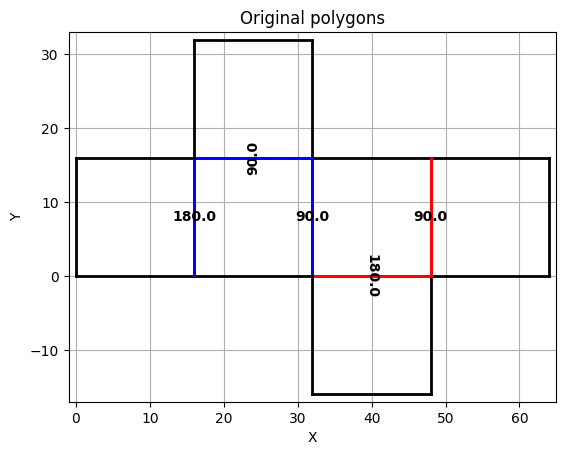

In [103]:
folder_name = 'data_files/'
# filename = 'single_45'
# filename = 'single_90'
# filename = 'single_180'
# filename = 'zig-zag'
# filename = 'cube'
# filename = 'bird'
filename = 'test'

polygons = read_data_file(folder_name + filename + '.dat')
draw_polygons(polygons, plot_title='Original polygons')

# polygons_final = add_hinges(polygons)
# draw_polygons(polygons_final, plot_title='Polygons with hinges')

# outer_countour = find_outer_countour(polygons)
# draw_polygons([[outer_countour, []]], plot_title='Outer countour')

In [ ]:
graph = polygon_array_to_graph(polygons)
    
if not has_cycles(graph):
    edges = dfs_tree_traversal(graph, 0, polygons)
    polygons_modified = transform_polygons(polygons, edges)
    polygons_final =  translate_connected_edges(polygons_modified)
    # polygons_surface = translate_to_continent(polygons_modified)

else:
    print('The origami pattern contains cycles, please manually make gcode file.')

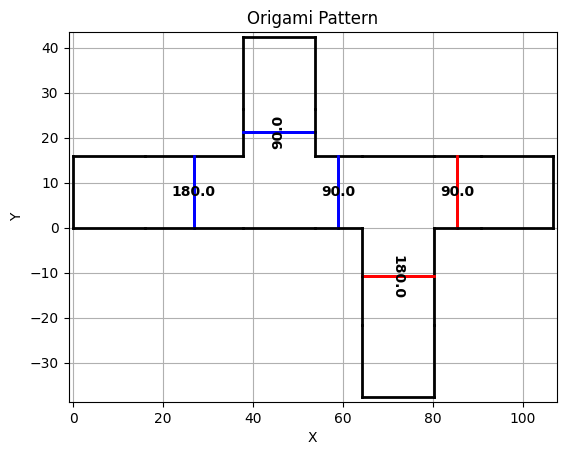

In [105]:
draw_polygons(polygons_surface)

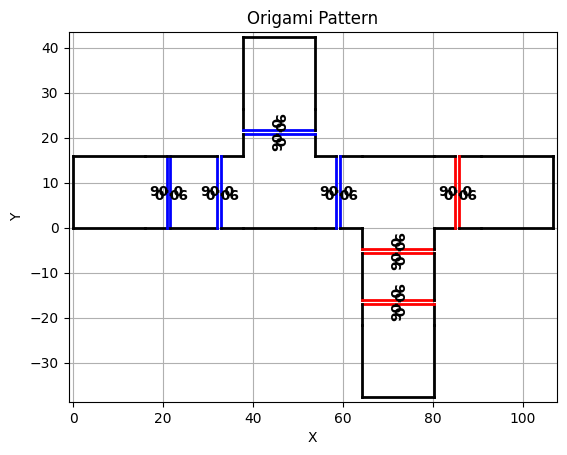

In [106]:
draw_polygons(polygons_final)

In [112]:
def translate_to_continent_for_surface(polygon_array):
    """
    将每个多边形与别的多边形相连的边进行处理，插入新顶点并更新连接信息。

    Args:
        polygon_array: 原始多边形数组。

    Returns:
        修改后的多边形数组。
    """

    transformed_polygon_array = []
    for polygon_index, (vertices, connections) in enumerate(polygon_array):
        new_vertices = vertices[:]  # 复制顶点列表，避免修改原始数据
        new_connections = []  # 创建新的连接信息列表

        insert_info = []  # 存储要插入的顶点信息 (索引，顶点坐标)
        vertex_count = len(vertices)

        # count = 0
        for conn in connections:
        # for i in range (len(connections)):
        #     conn = connections[-(i+1)]
            edge_index = int(conn[0])
                
            width = np.abs(calculate_width(conn[1], conn[2]))  # 使用绝对值
            translation_distance = delta / 2

            # 获取边的顶点坐标
            v1_index = (edge_index - 1) % vertex_count
            v2_index = edge_index % vertex_count
            v1 = vertices[v1_index]
            v2 = vertices[v2_index]

            # 计算新的顶点位置
            edge_direction = np.array(v2) - np.array(v1)
            normal_vector = np.array([edge_direction[1], - edge_direction[0]])

            # # 确保法向量指向多边形外部
            # center = np.mean(np.array(vertices), axis=0)
            # midpoint = (np.array(v1) + np.array(v2)) / 2.0
            # to_center = center - midpoint

            # if np.dot(normal_vector, to_center) > 0:
            #     normal_vector = -normal_vector

            # 归一化向量
            norm = np.linalg.norm(normal_vector)
            if norm == 0:
                print('Warning: Normal vector is zero. Maybe two vertices are duplicate.')
                continue  # 避免除以零
            normalized_vector = normal_vector / norm
            translation_vector = normalized_vector * translation_distance

            # 计算新的顶点位置
            new_v1 = np.array(v1) + translation_vector
            new_v2 = np.array(v2) + translation_vector

            # 存储插入信息（在 v2 之前插入 new_v1，然后在 v2 之前插入 new_v2）
            insert_info.append((v1_index, new_v1.tolist()))
            insert_info.append((v1_index, new_v2.tolist()))
            # if count == 0:
            # count += 1
   
        # print(insert_info)

        # 插入新顶点
        offset = 1
        # for i, insert_vertex in sorted(insert_info):  # 确保索引从小到大排列
        for i, insert_vertex in insert_info:
            new_vertices.insert(i + offset, insert_vertex)
            offset += 1

        # 更新连接信息
        offset = 1
        for conn in connections:
            edge_index = int(conn[0])
            #由于顶点插入到边的第二个顶点，因此坐标不会发生改变
            new_connections.append([edge_index + offset, conn[1], conn[2]]) #添加未修改的连接信息
            offset += 2

        transformed_polygon_array.append([new_vertices, new_connections])
        
    return transformed_polygon_array

In [ ]:
def merge_sublists_with_common_elements(data):
    """
    合并具有相同元素的子列表。

    参数：
        data: 包含子列表的列表。

    返回值：
        合并后的列表。
    """

    def find_connected_sublist_index(current_index, merged_groups):
        """
        查找与当前子列表有共同元素的已合并组的索引。
        """
        current_set = set(data[current_index])
        for i, group in enumerate(merged_groups):
            if current_set.intersection(group):  # 检查交集
                return i
        return -1  # 没有找到

    merged_groups = []  # 存储已合并的组

    for i in range(len(data)):
        connected_group_index = find_connected_sublist_index(i, merged_groups)

        if connected_group_index != -1:
            # 如果找到有共同元素的组，将当前子列表的元素添加到该组
            merged_groups[connected_group_index].update(data[i])
        else:
            # 如果没有找到，创建一个新的组
            merged_groups.append(set(data[i]))

    # 将集合转换为列表
    result = [list(group) for group in merged_groups]
    return result


def add_missing_numbers(data, n):
    """
    将 0 到 n-1 中未出现在 data 子列表中的数字作为单独的子列表添加到 data 中。

    参数：
        data: 包含子列表的列表。
        n:    范围上限（不包含）。

    返回值：
        添加了缺失数字后的列表。
    """

    all_elements = set()
    for sublist in data:
        all_elements.update(sublist)  # 将所有子列表的元素添加到集合中

    missing_numbers = []
    for k in range(n):
        if k not in all_elements:
            missing_numbers.append([k])  # 将缺失的数字作为单独的子列表

    return data + missing_numbers  # 将缺失数字的子列表添加到原列表

In [138]:
graph_surface = polygon_array_to_graph(translate_to_continent_for_surface(polygons_final))
    
if not has_cycles(graph_surface):
    edges_surface = dfs_tree_traversal(graph_surface, 0, polygons_final)
    # polygons_modified = transform_polygons(polygons, edges)
    # polygons_final =  translate_connected_edges(polygons_modified)
    # polygons_surface = translate_to_continent(polygons_modified)

else:
    print('The origami pattern contains cycles, please manually make gcode file.')

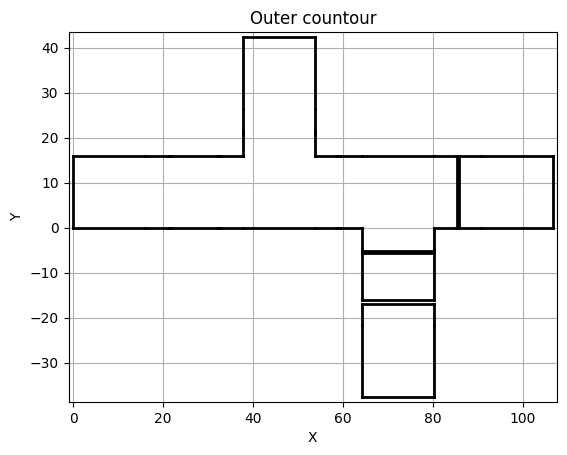

In [160]:
merge_list = []
for edge in edges_surface:
    if edge[1] < 0:
        merge_list.append(edge[0])
merge_list = merge_sublists_with_common_elements(merge_list)
merge_list = add_missing_numbers(merge_list, len(polygons_final))
polygons_merged = []
for polygon_list in merge_list:
    if len(polygon_list) == 1:
        polygons_merged.append(polygons_final[polygon_list[0]][0])
        continue
    polygon_to_merge = []
    for index in polygon_list:
        polygon_to_merge.append(polygons_final[index])
    polygon_to_merge = translate_to_continent_for_surface(polygon_to_merge)
    polygons_merged.append(extract_outer_polygon_vertices(polygon_to_merge))
draw_polygons([[polygons_merged[k], []] for k in range (len(polygons_merged))], plot_title='Outer countour')


In [162]:
def generate_surface_polygons(polygons_final, direction):
    graph_surface = polygon_array_to_graph(translate_to_continent_for_surface(polygons_final))
    
    if not has_cycles(graph_surface):
        edges_surface = dfs_tree_traversal(graph_surface, 0, polygons_final)

    else:
        print('The origami pattern contains cycles, please manually make gcode file.')
        
    merge_list = []
    
    if direction == 0:
        for edge in edges_surface:
            if edge[1] > 0:
                merge_list.append(edge[0])
    elif direction == 1:
        for edge in edges_surface:
            if edge[1] < 0:
                merge_list.append(edge[0])
    merge_list = merge_sublists_with_common_elements(merge_list)
    merge_list = add_missing_numbers(merge_list, len(polygons_final))
    polygons_merged = []
    for polygon_list in merge_list:
        if len(polygon_list) == 1:
            polygons_merged.append(polygons_final[polygon_list[0]][0])
            continue
        polygon_to_merge = []
        for index in polygon_list:
            polygon_to_merge.append(polygons_final[index])
        polygon_to_merge = translate_to_continent_for_surface(polygon_to_merge)
        polygons_merged.append(extract_outer_polygon_vertices(polygon_to_merge))
    # draw_polygons([[polygons_merged[k], []] for k in range (len(polygons_merged))], plot_title='Outer countour')

In [163]:
generate_surface_polygons(polygons_final, 0)